# Chapter 2: Implicit functions and automatic differentiation

## Efficient differentiation of fixed points


### Fixed point solvers



Let's start by looking at numerical fixed points, like those that underlie Deep Equilibrium models (DEQs). Our main goal is to explain how to perform efficient automatic differentiation of functions defined implicitly by fixed point equations.

Mathematically, for some function $f : \mathbb R^n \to \mathbb R^n$, we say $z \in \mathbb R^n$ is a _fixed point_ of $f$ if
$$
z = f(z).
$$

One way to think of a fixed point is that if we apply $f$, we stay in the same place. Many iterative algorithms, like optimization algorithms, fit into this pattern. As a result, the efficient automatic differentiation methods we develop here for fixed points can immediately be applied to efficient differentiation of optimization routines, simply by choosing $f$ to be the update function of the optimization algorithm in question.

Another way to think of a fixed point equation is as a system of (nonlinear) equations, like we might usually specify as $g(z) = 0$ except here we have $z$ on both sides. Indeed if we choose $g(z) = f(z) - z$ then we can reduce to the usual form of nonlinear equations.

More generally we might have a _parameterized_ function $f : \mathbb R^p \times \mathbb R^n \to \mathbb R^n$, which takes a paramter vector $a \in \mathbb R^p$. Then we'd write a fixed point as
$$
z = f(a, z).
$$
This corresponds to having a parameterized system of equations. Once parameters are involved, we might ask things like how a fixed point might change as we vary the value of the parameter. But before getting into questions like that, let's look at how to compute numerical fixed points.

Perhaps the simplest way to try to compute a numerical fixed point is naive [forward iteration](https://en.wikipedia.org/wiki/Fixed-point_iteration), where we iterate $z_{k+1} = f(z_k)$ until $z_{k+1}$ stays sufficiently close to $z_k$:

In [ ]:
import jax.numpy as jnp

def fwd_solver(f, z_init):
  z_prev, z = z_init, f(z_init)
  while jnp.linalg.norm(z_prev - z) > 1e-5:
    z_prev, z = z, f(z)
  return z

Whether this method succeeds depends on how we initialize it and on properties of $f$ (not least of which is whether $f$ has any fixed points!). And even if it does succeed, it might many steps to converge.

A more sophisticated method is a [Newton iteration](https://en.wikipedia.org/wiki/Newton%27s_method#k_variables,_k_functions), where we use derivative information about $f$ to take a smarter step (at the cost of using more computation per step):

In [ ]:
import jax

def newton_solver(f, z_init):
  f_root = lambda z: f(z) - z
  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))
  return fwd_solver(g, z_init)

Finally, a third method is [Anderson acceleration](https://en.wikipedia.org/wiki/Anderson_acceleration):

In [ ]:
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
  x0 = z_init
  x1 = f(x0)
  x2 = f(x1)
  X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
  F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])

  res = []
  for k in range(2, max_iter):
    n = min(k, m)
    G = F[:n] - X[:n]
    GTG = jnp.tensordot(G, G, [list(range(1, G.ndim))] * 2)
    H = jnp.block([[jnp.zeros((1, 1)), jnp.ones((1, n))],
                   [ jnp.ones((n, 1)), GTG]]) + lam * jnp.eye(n + 1)
    alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]

    xk = beta * jnp.dot(alpha, F[:n]) + (1-beta) * jnp.dot(alpha, X[:n])
    X = X.at[k % m].set(xk)
    F = F.at[k % m].set(f(xk))

    res = jnp.linalg.norm(F[k % m] - X[k % m]) / (1e-5 + jnp.linalg.norm(F[k % m]))
    if res < tol:
      break
  return xk

Given these solvers, we're ready to compute some fixed points! We'll look at a toy DEQ fixed-point layer, which can use any of the solvers we've developed:

In [ ]:
def fixed_point_layer(solver, f, params, x):
  z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
  return z_star

The layer takes as arguments
1. a solver, aptly named `solver`,
2. a function `f` for which to find the fixed point,
3. parameters `params`, and
4. input values `x`.

With those inputs, it computes as its output the fixed-point of the function.

Here's the function `f` we'll use, so that its paramters are just a weight matrix `W`:

In [ ]:
f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)

We'll initialize some random values for the parameters and inputs:

In [ ]:
from jax import random

ndim = 10
W = random.normal(random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
x = random.normal(random.PRNGKey(1), (ndim,))

And now we can use our solvers to find fixed points:

In [ ]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

[ 0.00649604 -0.7015958  -0.984715   -0.04196563 -0.615222   -0.4818384
  0.5783121   0.9556704  -0.08373158  0.8447803 ]


In [ ]:
z_star = fixed_point_layer(newton_solver, f, W, x)
print(z_star)

[ 0.00649406 -0.701595   -0.98471504 -0.04196503 -0.6152214  -0.48183855
  0.5783122   0.9556704  -0.08372932  0.8447797 ]


In [ ]:
z_star = fixed_point_layer(anderson_solver, f, W, x)
print(z_star)

[ 0.00649838 -0.70159334 -0.9847146  -0.04194273 -0.6152194  -0.48183322
  0.5783227   0.95566964 -0.08373427  0.84477484]


Up to numerical tolerances, we can see that we're computing about the same numerical fixed point regardless of the solver we use to find it. That is, we're decoupled the value to be computed from the way in which it's computed.

### Naive automatic differentiation through iterative solvers



We can already differentiate through our `fixed_point_layer` function. For example, we can use `jax.grad` to compute the gradient of the sum of the outputs with respect to the parameter matrix:

In [ ]:
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00756657 -0.81259    -1.1404793  -0.04861288 -0.7125525  -0.5580555
  0.6697878   1.1068411  -0.0970227   0.97842234]


As we might expect, up to numerical tolerances this gradient value doesn't depend on the method of computing the fixed point:

In [ ]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.0075213  -0.812574   -1.1404784  -0.04860311 -0.7125377  -0.5580563
  0.66979027  1.1068394  -0.09697371  0.97840786]


If we can already differentiate through these fixed point layers, what more is there to do?

The problem is that differentiating this way is extremely inefficient. We're differentiating through all the unrolled iterations of the solver. For each step, our automatic differentiation tool is storing values from the forward pass to be consumed on the backward pass. That means using a lot of memory!

To do something better, we need to think in terms of implicit function differentiation.

### The implicit function theorem



First, let's review some fundamentals and set up our differentiation notation. For a function $f : \mathbb R^n \to \mathbb R^m$, we'll denote the derivative evaluated at a point $x \in \mathbb R^n$ as
$$
\partial f(x) : \mathbb R^n \to \mathbb R^m.
$$

In words, $\partial f(x)$ is also a function, mapping from perturbations on the input space $\mathbb R^n$ to perturbations ont he output space $\mathbb R^m$. Moreover, $\partial f(x)$ is linear. We can think of writing a first-order Taylor series for $f$ at $x$ as
$$
f(x + v) = f(x) + \partial f(x) v + \mathcal O(\|v\|^2),
$$
where $v \in \mathbb R^n$ is a perturbation vector.

Notice that because $\partial f(x)$ is linear, we denote its appliation to the vector $v$ as $\partial f(x) v$, using juxtaposition rather than parentheses. That's convenient, and underscores that we can also think of $\partial f(x)$ as a matrix (with respect to the standard bases of the input and output spaces):
$$
\partial f(x) \in \mathbb R^{m \times n}.
$$

In this section, we'll mainly manipulate $\partial f(x)$ as a matrix.

One last bit of notation is for multivariate functions. When we want to differentiate with respect to just one argument, we'll use a subscript on the $\partial$ operator:
$$
\begin{align}
\partial_0 f(x, y) &\triangleq \partial g(x) \text{ where } g(x) = f(x, y),
\\
\partial_1 f(x, y) &\triangleq \partial g(y) \text{ where } g(y) = f(x, y).
\end{align}
$$

This notation is based on Spivak's classic _Calculus on Manifolds_ (1965), also used in Sussman and Wisdom's [_Struture and Interpretation of Classical Mechanics_](https://mitpress.mit.edu/sites/default/files/titles/content/sicm_edition_2/book.html) (2015) and [_Functional Differential Geometry_](https://mitpress.mit.edu/books/functional-differential-geometry) (2013). Both of the latter books are open-access. See in particular the Prologue of _Functional Differential Geometry_ for a defense of this notation. Another advantage of this notation is it has a direct correspondence to JAX's automatic differentiation APIs!

Now we're ready to state the version of the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem) that we'll use in these notes!

> **The implicit function theorem.** Let $f : \mathbb R^p \times \mathbb R^n \to \mathbb R^n$ and $a_0 \in \mathbb R^p$, $z_0 \in \mathbb R^n$ be such that
> 
> 1. $f(a_0, z_0) = 0$, and
> 2. $f$ is continuously differentiable with non-singular Jacobian $\partial_1 f(a_0, z_0) \in \mathbb R^{n \times n}$.
> 
> Then there exist open sets $S_{a_0} \subset \mathbb R^p$ and $S_{z_0} \subset R^n$ containing $a_0$ and $z_0$, respectively, and a unique continuous function $z^* : S_{a_0} \to S_{z_0}$ such that
> 1. $z_0 = z^*(a_0)$,
> 2. $f(a, z^*(a)) = 0 \quad \forall a \in S_{a_0}$, and
> 3. $z^*$ is differentiable on $S_{a_0}$.

See the book _The Implicit Function Theorem: History, Theory, and Applications_ (2002) by Krantz and Parks for a detailed history, and [notes on many variants of the implicit function theorem](http://www.its.caltech.edu/~kcborder/Notes/IFT.pdf).

We can think of $f(a, z) = 0$ as defining a system of nonlinear equations on $z$, parameterized by $a$. The point $(a_0, z_0)$ is a nominal solution. The theorem is powerful because it tells us that we can think of a _solution mapping_ funtion $z^*$, which satisfies
$$
f(a, z^*(a)) = 0 \quad \forall a \in S_{a_0}.
$$
Notice that both sides are functions of $a$, so we can differentiate both sides with respect to $a$ and evaluate at the point $(a_0, z_0)$ to get
$$
\partial_0 f(a_0, z_0) + \partial_1 f(a_0, z_0) \partial z^*(a_0) = 0.
$$
Rearranging, we find that the Jacobian of the solution mapping must be given by
$$
\partial z^*(a) = - [ \partial_1 f(a_0, z_0)]^{-1} \partial_0 f(a_0, z_0).
$$

That is, the Jacobian of the solution mapping can be expressed just in terms of Jacobians of $f$ at the solution point $(a_0, z_0)$. In other words, given an $a_0$, no matter how we solve the equations to compute $z_0$, we can still compute the Jacobian using just derivative information at the solution point. This can help us avoid differentiating through our iterative solvers!

We can adapt this to fixed points too. The implicit function theorem immediately applies, since we can translate our fixed point $z = f(a, z)$ to a nonlinear system $g(a, z) = 0$ via $g(a, z) \triangleq f(a, z) - z$, but we can redo the above derivative computation to get a nice expression.


To get a nice expression for the fixed point solution mapping Jacobian, we start at a fixed point
$$
z_0 = f(a_0, z_0),
$$
then we consider the local solution mapping $z^*$, which satisfies
$$
z^*(a) = f(a, z^*(a))
$$
as a function of $a$ around $a_0$. Then we differentiate both sides and evaluate at $(a_0, z_0)$,
$$
\partial z^*(a_0) = \partial_0 f(a_0, z_0) + \partial_1 f(a_0, z_0) \partial z^*(a_0),
$$
and rearrange to get
$$
\partial z^*(a_0) = [ I - \partial_1 f(a_0, z_0)]^{-1} \partial_1 f(a_0, z_0).
$$

Again, we have an expression for the derivative of the fixed point solution using only derivative information of the function $f$ at the fixed point itself. We can save memory!

Now that we have a mathematical expression for the derivative of the fixed point solution map, we just need to connect it to our automatic differentiation system.

### The two transformations of autodiff: JVPs and VJPs



Automatic differentiation (autodiff) is built on two transformations: Jacobian-vector products (JVPs) and vector-Jacobian products (VJPs). To power up our autodiff of fixed point solvers and other implicit functions, we'll have to connect our mathematical result to JVPs and VJPs.

In math, **Jacobian-vector products (JVPs)** model the mapping
$$
(x, v) \mapsto (f(x), \, \partial f(x) v),
$$
where we take $f : \mathbb R^n \to \mathbb R^m$, $x \in \mathbb R^n$, and $v \in \mathbb R^n$.
JVPs answer questions like:
* At a given input point $x$, if we nudge the input by a vector $v$, how does the output change to first order?
* What are the first two terms of the Taylor series $f(x + v) = f(x) + \partial f(x) v + \mathcal O(\|v\|^2)$?

In programs, JVPs underlie _forward-mode_ automatic differentiation, in the sense that if your autodiff system says it implements forward-mode, that means it gives you a way to compute the JVP for a function in your programming language.

In JAX, we can compute JVPs using `jax.jvp`


In [ ]:
def f(x):
  return jnp.sin(x) * x ** 2

x = 2.
y = f(x)
print(y)

3.6371896


In [ ]:
delta_x = 1.
y, delta_y = jax.jvp(f, (x,), (delta_x,))
print(y)
print(delta_y)

3.6371896
1.9726022


Here, `\Delta y` represents the value of $\Delta y = \partial f(x) \Delta x$, evaluated $x = 2$ and $\Delta x = 1$. We can check the result using a numerical approximation:

In [ ]:
eps = 1e-4
delta_y_approx = (f(x + eps * v) - f(x)) / eps
print(delta_y_approx)

1.97649


If your automatic differentiation system implements JVPs, that means you can evaluate Jacobian matrices one _column_ at a time. That is, to evaluate the full matrix $\partial f(x)$, you can feed in one-hot (standard-basis) vectors for $v$ into the JVP computation, and each will reveal a column of the Jacobian matrix. Each evaluation of a JVP has a similar cost to evaluation of the original function $f$, requiring at most a small constant multiple of the FLOPs and memory for typical functions.

In contrast, **vector-Jacobian products (VJPs)** let us evaluate Jacobian matrices one _row_ at a time. Mathematically, a VJP is the mapping
$$
(x, w) \mapsto (f(x), \, w^\mathsf{T} \partial f(x)),
$$
where $w \in \mathbb R^m$ is a vector that looks like the _output_ of $f$. While JVPs operate on perturbations, the interpretation of the vectors involved in VJPs is slightly more subtle. VJPs answer questions like:
* At a given input point $x \in \mathbb R^n$, if we have a vector $w \in \mathbb R^m$ that represents a scalar-valued linear function on perturbations $\Delta y$ of the output, e.g. representing how a scalar-valued loss function changes for small changes to the output, then what is a vector representing the corresponding linear function on perturbations $\Delta x$ to the input? That is, what is $\lambda \in \mathbb R^n$ such that
$$
\langle w, \, \Delta y \rangle = \langle w, \, \partial f(x) \, \Delta x \rangle = \langle \lambda, \, \Delta x \rangle,
$$
for any $\Delta x$, where we've defined $\Delta y = \partial f(x) \, \Delta x$?

This precise, if abstract, interpretation can prove in contexts like ODE differentiation, where we don't always have matrix algebra expressions available and instead must deal with more abstract linear maps.

Precise interpretation aside, the key idea is that VJPs let us build Jacobian matrices one _row_ at a time, with a computational cost in FLOPs that is just a small constant multiple of the cost of evaluating the original function. However, VJPs have a memory cost that scales with a notion of the _depth_ of a computation, making it much more memory intensive.

In programs, VJPs underlie _reverse-mode_ automatic differentiation, in the sense that if your autodiff system says it implements reverse-mode, that means it gives you a way to compute the VJP for a function in your programming language. The reason reverse-mode is so omnipresent in machine learning is due to the VJP's relationship to the gradient of a scalar-valued function, and the importance of gradient-based optimization of scalar-valued loss functions. If we have a scalar-valued loss function $\ell$ on the parameters of a neural network, where
$$
\ell : \mathbb R^n \to \mathbb R
$$
and where for some neural networks we might have $n \approx 10^9$, would we rather compute the Jacobian matrix of $\ell$ one row at a time, or one column at a time? (Notice the Jacobian of $\ell$ has one row and a billion columns!)

In fact, a good mathematial definition of the gradient $\nabla f(x) \in \mathbb R^n$ for scalar-valued functions $f$ is the vector such that
$$
\langle \nabla f(x), \, v \rangle = \partial f(x) v
$$
for all vectors $v \in \mathbb R^n$. We can compute $\nabla f(x)$ from the VJP map $(x, w) \mapsto (f(x), \, w^\mathsf{T} \partial f(x))$ simply by evaluating it at $(x, 1)$. Indeed, `jax.grad` is defined essentially as

```python
def grad(f):
  def gradfun(x):
    _, f_vjp = jax.vjp(f, x)
    grad_val, = f_vjp(1.)
    return grad_val
  return gradfun
```

As you might have guessed, `jax.vjp` is how we can compute VJPs in JAX:

In [ ]:
def f(x):
  return jnp.sin(x) * x ** 2

x = 2.
y = f(x)
print(y)

3.6371896


In [ ]:
w = 1.
y, f_vjp = jax.vjp(f, x)
lmbda, = f_vjp(w)
print(y)
print(lmbda)

3.6371896
1.9726022


The reason JVPs and VJPs are the fundamental building blocks of automatic differentiation has to do with function composition. If we have a composition of two functions $f = g \circ h$, we can write the JVP of $f$ by composing the JVPs of $g$ and $h$:

In [ ]:
h = jnp.sin
g = lambda x: x ** 3

def f_jvp(x, delta_x):
  y, delta_y = jax.jvp(h, (x,), (delta_x,))
  z, delta_z = jax.jvp(g, (y,), (delta_y,))
  return z, delta_z

z, delta_z = f_jvp(1., 1.)
print(z)
print(delta_z)

0.59582317
1.1477209


In [ ]:
# check against jax.jvp applied to f
f = lambda x: g(h(x))
z, delta_z = jax.jvp(f, (1.,), (1.,))
print(z)
print(delta_z)

0.59582317
1.1477209


Similarly, for the same composition $f = g \circ h$, we can write the VJP of $f$ by composing the VJPs of $g$ and $h$:

In [ ]:
def f_vjp(x, w):
  y, h_vjp = jax.vjp(h, x)
  z, g_vjp = jax.vjp(g, y)

  lmbda_y, = g_vjp(w)
  lmbda_x, = h_vjp(lmbda_y)

  return z, lmbda_x

In [ ]:
z, lmbda = f_vjp(1., 1.)
print(z)
print(lmbda)

0.59582317
1.1477209


In [ ]:
# check against jax.vjp applied to f
z, f_vjp_ = jax.vjp(f, 1.)
lmbda, = f_vjp_(1.)
print(z)
print(lmbda)

0.59582317
1.1477209


### Back to fixed points: fixed point JVPs and VJPs



Now we can connect our mathematical implicit differentiation expression to JAX's autodiff! Recall that for a fixed point solution mapping $z^*$, which for any paramter value $a \in \mathbb R^p$ gives us a solution to the fixed point equation
$$
z^*(a) = f(a, z^*(a)),
$$
we deduced that at a particular point $a_0$ with $z_0 = z^*(a_0)$ we must have
$$
\partial z^*(a_0) = [I - \partial_1 f(a_0, z_0)]^{-1} \partial_0 f(a_0, z_0).
$$
This expression relates the Jacobian of the solution mapping at a point to the Jacobians of the function $f$ at that point. To connect it to JAX, we just need to work out corresponding JVP and VJP expressions.

For the JVP, we want to compute $(a_0, v) \mapsto (z^*(a_0), \, \partial z^*(a_0) v)$, so we have
$$
\partial z^*(a_0) v = [I - \partial_1 f(a_0, z_0)]^{-1} \partial_0 f(a_0, z_0) v.
$$
We can evaluate this expression in two steps: first we can evaluate $u = \partial_0 f(a_0, z_0) v$ by applying the appropriate JVP of $f$. Then we can evaluate the final value $w = [I - \partial_1 f(a_0, z_0)]^{-1} u$ by rearranging to the get equation
$$
w = u + \partial_1 f(a_0, z_0) w.
$$
Notice that this expresses $w$ itself as the fixed point of an affine function, namely the function $w \mapsto u + \partial_1 f(a_0, z_0) w$, so we can use a fixed point solver to solve the linear system.


For the VJP, we want to compute $(a_0, w) \mapsto (z^*(a_0), \, w^\mathsf{T} \partial z^*(a_0))$, so similarly we can write
$$
w^\mathsf{T} \partial z^*(a_0) = w^\mathsf{T} [ I - \partial_1 f(a_0, z_0)]^{-1} \partial_0 f(a_0, z_0).
$$
We can again break this down into two steps: first we evaluate $u^\mathsf{T} = w^\mathsf{T} [I - \partial_1 f(a_0, z_0)]^{-1}$, which we can rewrite into the equation
$$
u^\mathsf{T} = w^\mathsf{T} + u^\mathsf{T} \partial_1 f(a_0, z_0)
$$
and thus we can compute $u$ as an affine fixed point. Second, we need to compute $u^\mathsf{T} \partial_0 f(a_0, z_0)$, which is just a VJP of $f$.

We can hook these implicit differentiation formulas into JAX's autodiff using [`jax.custom_jvp` and `jax.custom_vjp`](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html). Here's the VJP version:

In [ ]:
@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def fixed_point_layer(solver, f, params, x):
  z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
  return z_star

def fixed_point_layer_fwd(solver, f, params, x):
  z_star = fixed_point_layer(solver, f, params, x)
  return z_star, (params, x, z_star)

def fixed_point_layer_bwd(solver, f, res, z_star_bar):
  params, x, z_star = res
  _, vjp_a = jax.vjp(lambda params, x: f(params, x, z_star), params, x)
  _, vjp_z = jax.vjp(lambda z: f(params, x, z), z_star)
  return vjp_a(solver(lambda u: vjp_z(u)[0] + z_star_bar,
                      z_init=jnp.zeros_like(z_star)))

fixed_point_layer.defvjp(fixed_point_layer_fwd, fixed_point_layer_bwd)

We can check that the results are similar to the gradients we computed before, which relied on differentiating through all the iterations of the fixed point solver

In [ ]:
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00756657 -0.81259    -1.1404793  -0.04861288 -0.7125525  -0.5580555
  0.6697878   1.1068411  -0.0970227   0.97842234]


In [ ]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.0075213  -0.812574   -1.1404784  -0.04860311 -0.7125377  -0.5580563
  0.66979027  1.1068394  -0.09697371  0.97840786]


In [ ]:
g = jax.grad(lambda W: fixed_point_layer(anderson_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00759155 -0.8125818  -1.140499   -0.04842732 -0.7127035  -0.5580155
  0.66974455  1.1068457  -0.09696102  0.97841185]


These agree with the values we found before, but they're being computed much more efficiently!



Here are the main take-aways:
1.   Generic autodiff works on fixed-point iterations, but it's **memory-inefficient** (and usually FLOP-inefficient and numerically unstable too) to differentiate through the solver.
2.   Instead, we can use **implicit differentiation**, which only needs the final fixed point value (rather than all the iterates).
3.   Implicit differentiation looks like "linearize at the fixed point, solve the linear system". We can solve the linear system using a fixed point iteration again, though we're free to solve it howerever we want.

### Improved solver implementations



This section is JAX-specific.

We've seen that our solver implementations so far can be naively differentiated with JAX's autodiff, and also that we can define custom differentiation rules for them based on implicit differentiation. However, we can improve these implementations to be more efficient, and to support more JAX transformations.

Our previous `fwd_solver` implementation was

In [ ]:
def fwd_solver(f, z_init):
  z_prev, z = z_init, f(z_init)
  while jnp.linalg.norm(z_prev - z) > 1e-5:
    z_prev, z = z, f(z)
  return z

If we instead implement this using a [`jax.lax.while_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.while_loop.html?highlight=while_loop) structured control flow primitive, then we gain the ability to compile it using `jax.jit` and automatically batch it with `jax.vmap`. The rewrite looks like

In [ ]:
from jax import lax

def fwd_solver(f, z_init):
  def cond_fun(carry):
    z_prev, z = carry
    return jnp.linalg.norm(z_prev - z) > 1e-5

  def body_fun(carry):
    _, z = carry
    return z, f(z)

  init_carry = (0, z_init, f(z_init))
  _, z_star = lax.while_loop(cond_fun, body_fun, init_carry)
  return z_star

Luckily, `newton_solver` doesn't need to change at all, since it's implemented in terms of `fwd_solver`.

We can similarly update `anderson_solver`:

In [ ]:
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
  x0 = z_init
  x1 = f(x0)
  x2 = f(x1)
  X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
  F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])

  def step(n, k, X, F):
    G = F[:n] - X[:n]
    GTG = jnp.tensordot(G, G, [list(range(1, G.ndim))] * 2)
    H = jnp.block([[jnp.zeros((1, 1)), jnp.ones((1, n))],
                   [ jnp.ones((n, 1)), GTG]]) + lam * jnp.eye(n + 1)
    alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]

    xk = beta * jnp.dot(alpha, F[:n]) + (1-beta) * jnp.dot(alpha, X[:n])
    X = X.at[k % m].set(xk)
    F = F.at[k % m].set(f(xk))
    return X, F

  # unroll the first m steps
  for k in range(2, m):
    X, F = step(k, k, X, F)
    res = jnp.linalg.norm(F[k] - X[k]) / (1e-5 + jnp.linalg.norm(F[k]))
    if res < tol or k + 1 >= max_iter:
      return X[k], k

  # run the remaining steps in a lax.while_loop
  def body_fun(carry):
    k, X, F = carry
    X, F = step(m, k, X, F)
    return k + 1, X, F

  def cond_fun(carry):
    k, X, F = carry
    kmod = (k - 1) % m
    res = jnp.linalg.norm(F[kmod] - X[kmod]) / (1e-5 + jnp.linalg.norm(F[kmod]))
    return (k < max_iter) & (res >= tol)

  k, X, F = lax.while_loop(cond_fun, body_fun, (k + 1, X, F))
  return X[(k - 1) % m], k

We can check that these new implementations compute the same values as before, though they're now much faster since the underlying loop is compiled for whatever backend we're using (CPU, GPU, or TPU):

In [ ]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

[ 0.00649604 -0.7015958  -0.984715   -0.04196563 -0.615222   -0.4818384
  0.5783121   0.9556704  -0.08373158  0.8447803 ]


In [ ]:
z_star = fixed_point_layer(newton_solver, f, W, x)
print(z_star)

[ 0.00649406 -0.701595   -0.98471504 -0.04196503 -0.6152214  -0.48183855
  0.5783122   0.9556704  -0.08372932  0.8447797 ]


In [ ]:
z_star = fixed_point_layer(anderson_solver, f, W, x)
print(z_star)

[ 0.00649838 -0.70159334 -0.9847146  -0.04194273 -0.6152194  -0.48183322
  0.5783227   0.95566964 -0.08373427  0.84477484]


We can check that our implicit differentiation still works with these new solvers:

In [ ]:
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00756657 -0.81259    -1.1404793  -0.04861288 -0.7125525  -0.5580555
  0.6697878   1.1068411  -0.0970227   0.97842234]


In [ ]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.0075213  -0.812574   -1.1404784  -0.04860311 -0.7125377  -0.5580563
  0.66979027  1.1068394  -0.09697371  0.97840786]


In [ ]:
g = jax.grad(lambda W: fixed_point_layer(anderson_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00759155 -0.8125818  -1.140499   -0.04842732 -0.7127035  -0.5580155
  0.66974455  1.1068457  -0.09696102  0.97841185]


## Differentiation of functions defined by ordinary differential equations (ODEs)

### ODEs and `odeint`



We want to differentiate through ordinary differential equation (ODE) solvers, like `jax.scipy.integrate`'s `odeint`. Mathematically, primitives like `odeint` solve initial value problems (IVPs) of the form
\begin{equation}
\dot y(t) = f(t, y(t)), \qquad y(0) = y_0,
\end{equation}
for some dynamics function $f : \mathbb{R} \times \mathbb{R}^n \to \mathbb{R}^n$ and initial value $y_0 \in \mathbb{R}^n$, where we use the traditional shorthand notation $\dot y(t) \equiv \partial y(t)$, and treat $\partial y(t) \in \mathbb{R}^n$ rather than $\mathbb{R}^{n \times 1}$ by squeezing out the singleton dimension introduced by differentiation with respect to time. In words, for any value of $t$, the value of $y(t) \in \mathbb{R}^n$ is implicitly defined by the dynamics function $f$ and the initial value $y_0$ via the ODE. (We'll assume that the function $y$ exists and is uniquely defined by these input data. There are sufficient conditions on the differentiability of $f$ for this to hold true, and they can be related to the implicit function theorem!)

In Python, we give as input to `odeint` a Python callable representing $f$, an array representing the initial value $y_0$, and a sequence of times $0 < t_1 < \cdots t_K$. Then `odeint` computes as its output the values of $y(t_1), \ldots, y(t_K)$:

In [ ]:
from functools import partial
from jax.experimental.ode import odeint
import jax.numpy as jnp

def f(state, t, rho, sigma, beta):
  x, y, z = state
  return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

ys = odeint(partial(f, rho=28., sigma=10., beta=8./3),
            y0=jnp.array([1., 1., 1.]),
            t=jnp.linspace(0, 10., 10000))

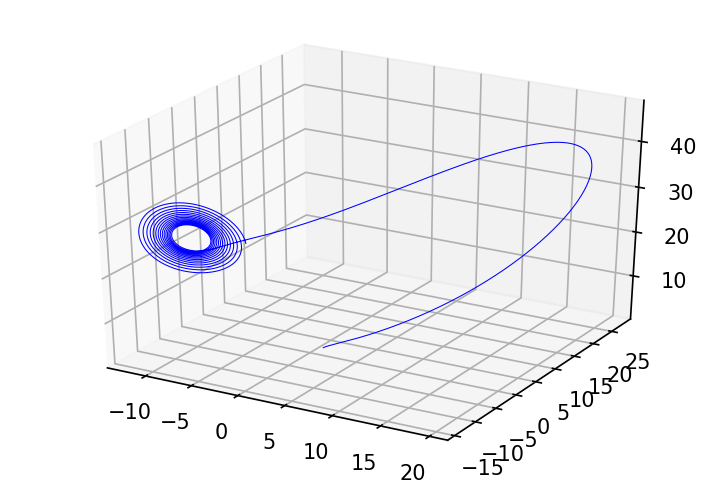

In [ ]:
import matplotlib.pyplot as plt

def plot_3d_path(ax, ys, color):
  x0, x1, x2 = ys.T
  ax.plot(x0, x1, x2, lw=0.5, color=color)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'b');

Thus `odeint` defines an implicit function from its input data (the parameters of $f$ and the initial value $y_0$) to its output. It decouples the specification of what values are to be computed (the solution to the ODE IVP) from how they're computed: there are many alternative algorithms to solve ODE IVPs. Below are two simple ones we'll use for concreteness.

The most straightforward integrator is first-order forward Euler's method:

In [ ]:
from jax import lax

def odeint_euler(f, y0, t, *args):
  def step(state, t):
    y_prev, t_prev = state
    dt = t - t_prev
    y = y_prev + dt * f(y_prev, t_prev, *args)
    return (y, t), y
  _, ys = lax.scan(step, (y0, t[0]), t[1:])
  return ys

ys = odeint_euler(f, jnp.array([-2., -2., 2.]), jnp.linspace(0, 10., 10000),
                  28., 10., 8./3)

By using `lax.scan`, we compile the integrator loop into a single primitive execution.

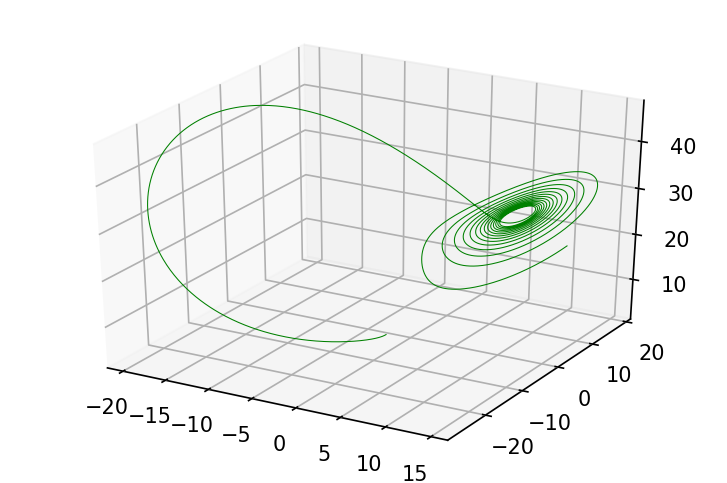

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'g')

A slightly more sophisticated integrator is a 4th order Runge-Kutta scheme, which uses multiple evaluations of the dynamics function to better approximate the value of the integral over the step:

In [ ]:
def odeint_rk4(f, y0, t, *args):
  def step(state, t):
    y_prev, t_prev = state
    h = t - t_prev
    k1 = h * f(y_prev, t_prev, *args)
    k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
    k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
    k4 = h * f(y_prev + k3, t + h, *args)
    y = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y, t), y
  _, ys = lax.scan(step, (y0, t[0]), t[1:])
  return ys

In [ ]:
ys = odeint_rk4(f, jnp.array([5., 5., 5.]), jnp.linspace(0, 10., 10000),
                28., 10., 8./3)

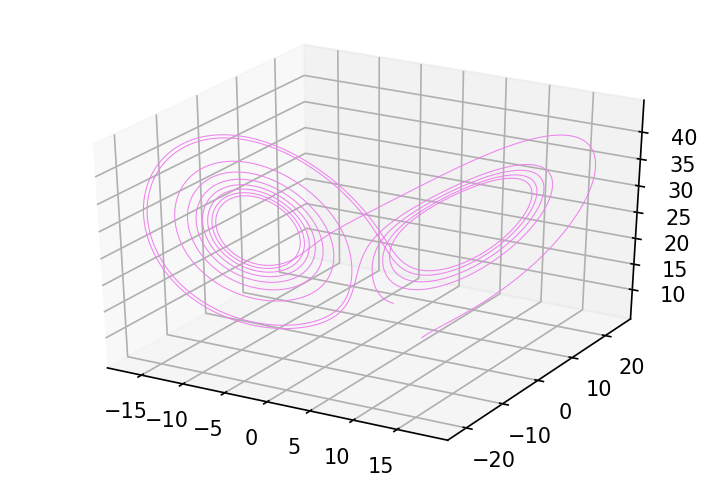

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'violet');

The `odeint` implementation in JAX uses an adaptive step size scheme.

As with fixed points, we could just differentiate through the operation of the numerical ODE integration algorithm. But that would quickly prove too memory-intensive for applications like Neural ODEs.

To understand how to _efficiently_ automatically differentiate through the `odeint` Python function, we'll want to first understand how to think about mathematical differentiation of functions defined via ODEs. That is, we'll want to formulate questions around how the value of the solution function $y$ changes as we make small changes to the parameters of $f$ or to the initial value $y_0$.

To simplify the mathematical exposition, for most of this section we'll assume that we only want to evaluate the solution function at one time index $T$, rather than a sequence of times $t_1, \ldots, t_K$. That is, we'll specialize to ODE IVPs of the form
$$
\begin{align}
\text{compute} \quad y(T)&~ \\
\text{such that} \quad \dot y(t) &= f(t, y(t)) \quad \forall t \in [0, T], \\
\quad y(0) &= y_0,
\end{align}
$$
where $f$ and $y_0$ are the input data.
Once we work out how to handle differentiation using only the output time $y(T)$, the extension to multiple time indices will be straightforward.

### Differentiation of ODEs


Consider an ODE IVP parameterized by $a \in \mathbb{R}^p$ and $b \in \mathbb{R}^n$,
$$
\partial_0 y(t, a, b) = f(t, y(t, a, b), a), \qquad y(0, a, b) = b.
$$
Notice that because the solution $y$ depends on $a$ and $b$, we write it as a function of those values.

We want to answer questions like

*   **Jacobian-vector products for forward-mode.** If we nudge the parameters $a$ and $b$ to be $a + \Delta a$ and $b + \Delta b$, how does the value of $y$ at time $T$ change, to first order? That is, what is the value of $\partial_1 y(T, a, b) \, \Delta a + \partial_2 y(T, a, b) \, \Delta b$?
*   **Vector-Jacobian products for reverse-mode.** Given a linear function on perturbations to the final value of $y$ at time $T$, perhaps representing how a loss function changes given small perturbations to the value of $y(T, a, b)$, what are linear approximations to how the loss function changes as a function of small perturbations to the parameters $a$ and $b$? That is, given a vector $w \in \mathbb{R}^n$ representing a linear function on perturbations to $y(T, a, b)$, what are $w^\mathsf{T} \partial_1 y(T, a, b)$ and $w^\mathsf{T} \partial_2 y(T, a, b)$?


### Jacobian-vector products for forward-mode



To understand how the solution changes given small perturbations to the value of $a$, we assume the ODE solution exists for values in a neighborhood of $a$ and differentiate both sides of the ODE equation as functions of $a$:
$$
\partial_1 \partial_0 y(t, a, b) = \partial_1 f(t, y(t, a, b), a) \partial_1 y(t, a, b) + \partial_2 f(t, y(t, a, b), a) .
\tag{*}
$$
Notice that because partial derivatives commute we can rearrange the left-hand side via
$$
\partial_1 \partial_0 y(t, a, b) = \partial_0 \partial_1 y(t, a, b).
$$
Both sides of this equation are $n \times p$ matrices (squeezing out the singleton dimension introduced by differentiation with respect to time). We can apply it to a particular perturbation $\Delta a \in \mathbb{R}^p$ as
$$
\partial_0 \partial_1 y(t, a, b) \, \Delta a = \partial_1 f(t, y(t, a, b), a)  \partial_1 y(t, a, b) \, \Delta a + \partial_2 f(t, y(t, a, b), a) \, \Delta a,
$$
where both sides are now vectors in $\mathbb{R}^n$.

This new equation itself looks like an ODE! To clean up the notation, we can define a new function $z(t, a, b) \triangleq \partial_1 y(t, a, b) \, \Delta a$ and think of it as a new state vector component. Intuitively, $z(t, a, b)$ represents the perturbation to the value of $y(t, a, b)$ given our nudges to the parameter values. The differentiation equation $(*)$ gives its dynamics:

$$
\begin{bmatrix} \partial_0 y(t, a, b) \\ \partial_0 z(t, a, b) \end{bmatrix}
=
\begin{bmatrix}
f(t, y(t, a, b), a) \\
g(t, y(t, a, b), z(t, a, b), a)
\end{bmatrix}
$$
where
$$
g(t, y, z, a) \triangleq \partial_1 f(t, y, a) z + \partial_2 f(t, y, a) \, \Delta a .
$$

What about initial conditions? Those line up nicely as well: the perturbation to the value of $y(0, a, b)$ is by definition $\Delta b$, so we have
$$
\begin{bmatrix} y(0, a, b) \\ z(0, a, b) \end{bmatrix}
=
\begin{bmatrix}
b \\ \Delta b
\end{bmatrix}.
$$


The end result is that we can express the JVP in terms of an augmented ODE system, and so in code we can implement the JVP rule as a new call to `odeint`, using [JAX's `custom_jvp` mechanism](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html):

In [ ]:
import jax

odeint_rk4 = jax.custom_jvp(odeint_rk4, nondiff_argnums=(0,))

@odeint_rk4.defjvp
def odeint_rk4_jvp(f, primals, tangents):
  y0, t, *args = primals
  delta_y0, _, *delta_args = tangents
  nargs = len(args)

  def f_aug(aug_state, t, *args_and_delta_args):
    primal_state, tangent_state = aug_state
    args, delta_args = args_and_delta_args[:nargs], args_and_delta_args[nargs:]
    primal_dot, tangent_dot = jax.jvp(f, (primal_state, t, *args), (tangent_state, 0., *delta_args))
    return jnp.stack([primal_dot, tangent_dot])

  aug_init_state = jnp.stack([y0, delta_y0])
  aug_states = odeint_rk4(f_aug, aug_init_state, t, *args, *delta_args)
  ys, ys_dot = aug_states[:, 0, :], aug_states[:, 1, :]
  return ys, ys_dot

With this `odeint` JVP rule, we can now investiagte questions like: if we were to nudge the third component of the starting point a bit, how would that nudge the solution path?

In [ ]:
def evolve(y0):
  return odeint_rk4(f, y0, jnp.linspace(0, 1., 1000), 28., 10., 8./3)

y0 = jnp.array([5., 5., 5.])
delta_y0 = jnp.array([0., 0., 1.])
ys, delta_ys = jax.jvp(evolve, (y0,), (delta_y0,))

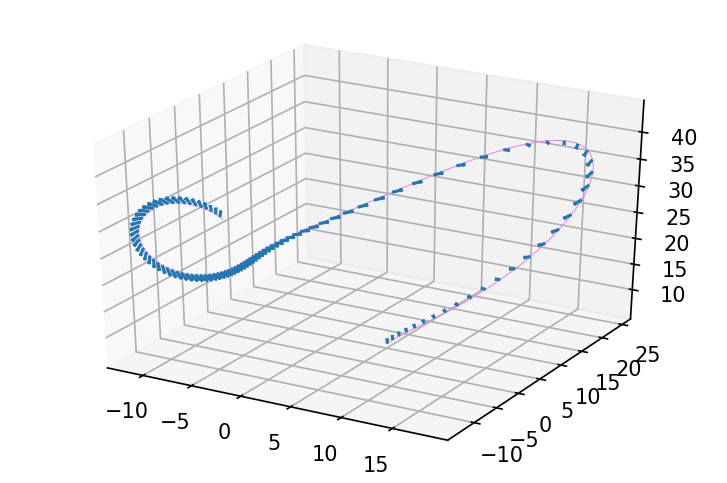

In [ ]:
def plot_3d_path_with_delta(ax, ys, delta_ys, color):
  x0, x1, x2 = ys.T
  dx0, dx1, dx2 = delta_ys.T

  skip = 10
  ax.plot(x0, x1, x2, lw=0.5, color=color)
  ax.quiver(x0[::skip], x1[::skip], x2[::skip], dx0[::skip], dx1[::skip], dx2[::skip])

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

Or, if we nudge one of the dynamics parameters, how would this trajectory change?

In [ ]:
def evolve(y0, rho, sigma, beta):
  return odeint_rk4(f, y0, jnp.linspace(0, 1., 1000), rho, sigma, beta)

y0 = jnp.array([5., 5., 5.])
delta_y0 = jnp.array([0., 0., 0.])

rho = 28.
sigma = 10.
beta = 8./3

delta_rho = 0.
delta_sigma = 1.
delta_beta = 0.

ys, delta_ys = jax.jvp(evolve,
                       (y0, rho, sigma, beta),
                       (delta_y0, delta_rho, delta_sigma, delta_beta))

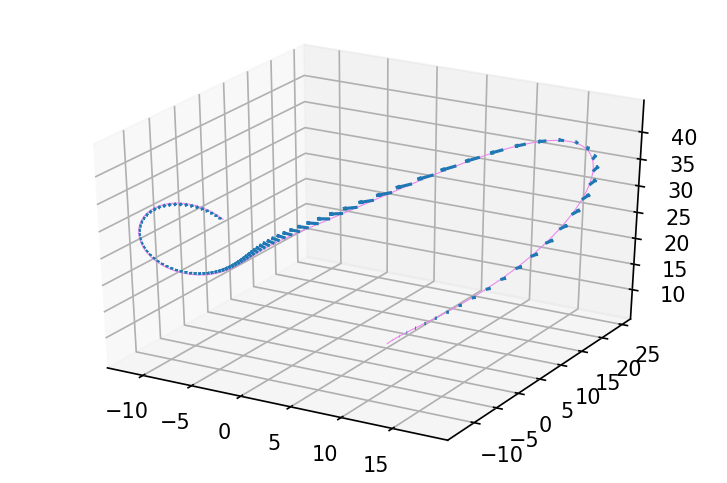

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

In [ ]:
delta_rho = 0.
delta_sigma = 0.
delta_beta = 1.

ys, delta_ys = jax.jvp(evolve,
                       (y0, rho, sigma, beta),
                       (delta_y0, delta_rho, delta_sigma, delta_beta))

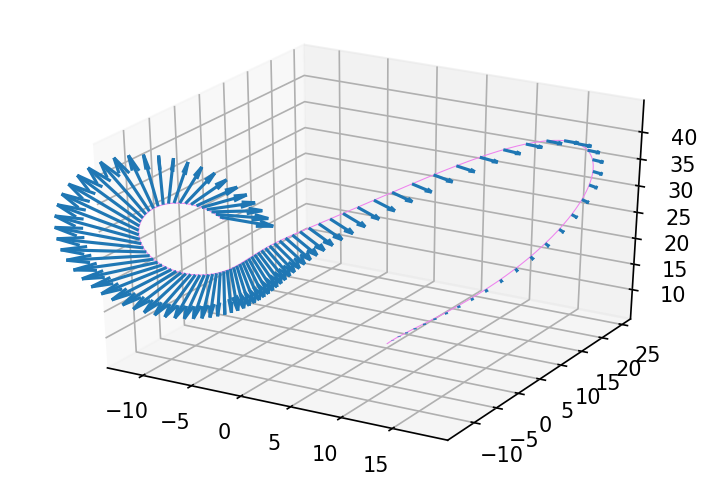

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

Looks like the trajectory is really sensitive to changes in the `beta` parameter!

We can check these by actually nudging the value of the parameter and seeing how the trajectory changes:

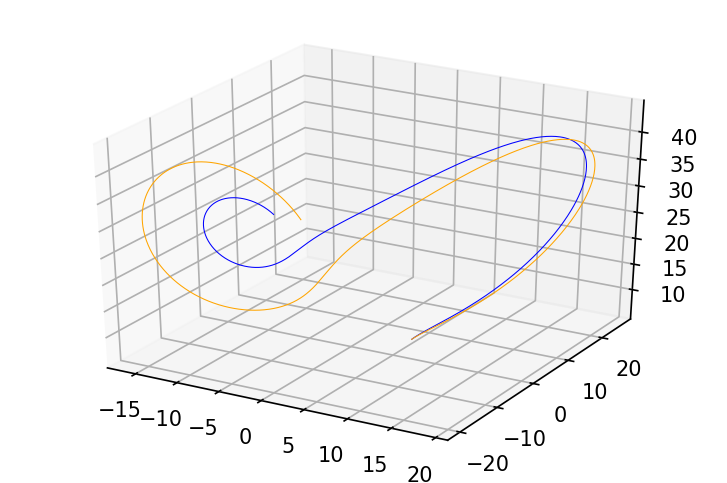

In [ ]:
perturbed_ys = evolve(y0, rho, sigma, beta + 1.)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'blue')
plot_3d_path(ax, perturbed_ys, 'orange')

### Vector-Jacobian products for reverse mode

To work out a VJP we only need to consider _transposing_ an ODE IVP with certain linearity structure. We can then combine transposition with the JVP linearization result to get a VJP.

Consider an ODE IVP of the form
$$
\begin{equation}
\partial_0 z(t, u, v) = A(t) z(t, u, v) + B(t)u, \qquad z(0, u, v) = v,
\end{equation}
$$
for some vectors $u \in \mathbb{R}^p$ and $v \in \mathbb{R}^n$, where the state has dimension $z(t, u, v) \in \mathbb{R}^n$. At each time $t$, $A(t) \in \mathbb{R}^{n \times n}$ and $B(t) \in \mathbb{R}^{n \times p}$ are matrices.

Notice that the mapping $(u, v) \mapsto z(T, u, v)$ is linear. That is, if we take $(u, v) = (0, 0)$ then $z \equiv 0$ is a solution. Moreover, if $z_1$ and $z_2$ are solutions for inputs $(u_1, v_1)$ and $(u_2, v_2)$, respectively, then for scalars $\alpha, \beta \in \mathbb{R}$ we have that $\alpha z_1 + \beta z_2$ is a solution given the input $(\alpha u_1 + \beta u_2, \alpha v_1 + \beta v_2)$, which we can check by forming the corresponding linear combination of the ODE equations for $z_1$ and $z_2$.

Because $(u, v) \mapsto z(T, u, v)$ is linear, for any linear function on the value of $z(T, u, v)$ we can define a linear function on $(u, v)$ by composition. In particular, for a given vector $w \in \mathbb{R}^n$, we want to find vectors $\lambda_u \in \mathbb{R}^p$ and $\lambda_v \in \mathbb{R}^n$ such that
$$
\langle w, \, z(T, u, v) \rangle = \langle \lambda_u, \, u \rangle + \langle \lambda_v, \, v \rangle
$$
for any vectors $u$ and $v$.

**First consider the special case $B(t) \equiv 0$**, so we have
$$
\partial_0 z(t, v) = A(t) z(t, v), \qquad z(0, v) = v. \tag{*}
$$
For a given $w$, we want to find $\lambda$ such that
$$
\langle w, \, z(T, v) \rangle = \langle \lambda, \, v \rangle = \langle \lambda, \, z(0, v) \rangle.
$$
In words, we know a representer for this linear map acting on the state at time $t=T$, namely the vector $w$, and we want to find a representer for the linear map acting on the state at time $t=0$, namely the vector $\lambda$.
Since the basic task is to translate from a representer for one value of $t$ to another, we could generalize the question to ask for a _function_ $t \mapsto \lambda(t)$ such that
$$
\langle w, \, z(T, v) \rangle = \langle \lambda(t), \, z(t, v) \rangle \qquad \forall t \in [0, T].
$$
Then in particular taking $t=T$ we'd have $\lambda(T) = w$, and taking $t = 0$ we'd have the vector $\lambda(0)$ with the property
$$
\langle w, \, z(T, v) \rangle = \langle \lambda(0), \, z(0, v) \rangle = \langle \lambda(0), \, v \rangle.
$$
We can find such a function $\lambda$ by fixing $\lambda(T) = w$ and ensuring the value of $\langle \lambda(t), \, z(t, v) \rangle$ does not change as a function of time:
$$
\begin{align}
0
&=\partial ( t \mapsto \langle \lambda(t), \, z(t, v) \rangle )
\\
&= \langle \partial \lambda(t), \, z(t, v) \rangle + \langle \lambda(t), \, \partial_0 z(t, v) \rangle
\\
&= \langle \partial \lambda(t), \, z(t, v) \rangle + \langle \lambda(t), \, A(t) z(t, v) \rangle
\\
&= \langle \partial \lambda(t) + A(t)^\mathsf{T} \lambda(t), \, z(t, v) \rangle,
\end{align}
$$
where on the third line we have used the linear ODE $(*)$. Thus to attain the aim of having the value of $\langle \lambda(t), \, z(t, v) \rangle$ not change in time, and to satisfy $\lambda(T) = w$, it is sufficient to choose $\lambda$ to solve the ODE IVP
$$
\partial \lambda(t) = - A(t)^\mathsf{T} \lambda(t), \qquad \lambda(T) = w.
$$
This system is known as the _adjoint system_ to the linear ODE $\partial z(t) = A(t) z(t)$.

Intuitively, at each time $t$, the value of $\lambda(t)$ represents how the value of $\langle w, \, z(T, v) \rangle$ would change given a perturbation in the value of $z(t, v)$. By tracking that quantity at all time points $t$, we can relate the known value at $t=T$ (namely $\lambda(T) = w$) to the value of interest at $t=0$.



**For the more general case of $B(t) \not\equiv 0$**, consider again the linear ODE IVP
$$
\begin{equation}
\partial_0 z(t, u, v) = A(t) z(t, u, v) + B(t)u, \qquad z(0, u, v) = v,
\end{equation}
$$
and the task of being given a $w \in \mathbb{R}^n$ and needing to compute $\lambda_u \in \mathbb{R}^p$ and $\lambda_v \in \mathbb{R}^n$ such that
$$
\langle w, \, z(T, u, v) \rangle = \langle \lambda_u, \, u \rangle + \langle \lambda_v, \, v \rangle.
$$

If we use the same function $\lambda$ as above, which satisfies $\partial \lambda(t) = -A(t)^\mathsf{T} \lambda(t)$, because of the new term involving $B$ in the ODE for $z$ we'll no longer have $\langle w, \, z(T, u, v) \rangle = \langle \lambda(t), \, z(t, u, v)\rangle $ at all times $t \in [0, T]$ as we did when $B \equiv 0$. But we can write out the difference as an integral over time of the difference between $\partial_0 z(t, u, v)$ and $A(t) z(t, u, v)$:
$$
\begin{align}
\langle w, \, z(T, u, v) \rangle - \langle \lambda(t), \, z(t, u, v) \rangle
&= \int_t^T \langle \lambda(\tau), \, \partial_0 z(\tau, u, v) - A(\tau) z(\tau, u, v) \rangle \, \mathrm{d}\tau
\\
&= \int_t^T \langle \lambda(\tau), \, B(\tau) u \rangle \, \mathrm{d} \tau.
\end{align}
$$
Re-arranging, we have that
$$
\langle w, \, z(T, u, v) \rangle = \langle \lambda(t), \, z(t, u, v) \rangle + \langle \textstyle \int_t^T B(\tau)^\mathsf{T} \lambda(\tau) \, \mathrm{d}\tau, \, u \rangle,
$$
for all $t \in [0, T]$, and in particular at time $t=0$ we have
$$
\langle w, \, z(T, u, v) \rangle = \langle \lambda(0), \, z(0, u, v) \rangle + \langle \textstyle \int_0^T B(\tau)^\mathsf{T} \lambda(\tau) \, \mathrm{d}\tau, \, u \rangle.
$$
That is, we've found that we can write the vectors $\lambda_u$ and $\lambda_v$ that we're after as
$$
\begin{align}
\lambda_u &= \int_0^T B(t)^\mathsf{T} \lambda(t) \, \mathrm{d}t,
\\
\lambda_v &= \lambda(0).
\end{align}
$$

To compute these quantities, particularly the integral defining $\lambda_u$, we can set up a new augmented ODE IVP:
$$
\begin{bmatrix}
\partial \lambda(t) \\ \partial \gamma(t)
\end{bmatrix}
=
\begin{bmatrix}
- A(t)^\mathsf{T} \lambda(t) \\
B(t)^\mathsf{T} \lambda(t)
\end{bmatrix},
\qquad
\begin{bmatrix}
\lambda(T) \\ \gamma(T)
\end{bmatrix}
=
\begin{bmatrix}
w \\ 0
\end{bmatrix}.
$$
By solving for the value of this augmented state at time $t=0$, which we can do using a call to `odeint`, we compute $\lambda_u$ and $\lambda_v$.

To build a full VJP, we can put this transposition result together with the JVP result derived above. That is, given the ODE system
$$
\partial_0 y(t, a, b) = f(t, y(t, a, b), a), \qquad y(0, a, b) = b.
$$
consider again the JVP ODE
$$
\begin{bmatrix} \partial_0 y(t, a, b) \\ \partial_0 z(t, a, b) \end{bmatrix}
=
\begin{bmatrix}
f(t, y(t, a, b), a) \\
\partial_2 f(t, y, a) \, \Delta a + \partial_1 f(t, y, a) z
\end{bmatrix},
\qquad
\begin{bmatrix} y(0, a, b) \\ z(0, a, b) \end{bmatrix}
=
\begin{bmatrix}
b \\ \Delta b
\end{bmatrix}.
$$
We can apply the transposition result to the second block component of the JVP ODE by choosing
$$
\begin{align}
A(t) \triangleq \partial_1 f(t, y, a),
\qquad
B(t) \triangleq \partial_2 f(t, y, a),
\end{align}
$$
so that the joint system of interest becomes
$$
\begin{bmatrix}
\partial_0 y(t, a, b) \\
\partial_0 \lambda(t) \\
\partial_0 \gamma(t)
\end{bmatrix}
=
\begin{bmatrix}
f(t, y(t, a, b), a) \\
- \partial_1 f(t, y(t, a, b), a)^\mathsf{T} \lambda(t) \\
\partial_2 f(t, y(t, a, b), a)^\mathsf{T} \lambda(t)
\end{bmatrix},
\qquad
\begin{bmatrix}
y(T, a, b) \\
\lambda(T) \\
\gamma(T)
\end{bmatrix}
=
\begin{bmatrix}
y_T \\
w \\
0
\end{bmatrix}.
$$
We can solve this full joint system with a call to `odeint`. As an alternative, if we instead save values of $t \mapsto (t, y(t, a, b))$ during the forward pass and then use them to form an interpolation approximation to $t \mapsto y(t, a, b)$, on the backward pass we can query the interpolation so that we need only solve the linearized ODE
$$
\begin{bmatrix}
\partial_0 \lambda(t) \\
\partial_0 \gamma(t)
\end{bmatrix}
=
\begin{bmatrix}
- \partial_1 f(t, y(t, a, b), a)^\mathsf{T} \lambda(t) \\
\partial_2 f(t, y(t, a, b), a)^\mathsf{T} \lambda(t)
\end{bmatrix},
\qquad
\begin{bmatrix}
\lambda(T) \\
\gamma(T)
\end{bmatrix}
=
\begin{bmatrix}
w \\
0
\end{bmatrix}.
$$